# Detecting COVID-19 in X-ray images

## Import the packages

In [1]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas

Using TensorFlow backend.
/Users/alirezalouni/Desktop/virus/my_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alirezalouni/Desktop/virus/my_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alirezalouni/Desktop/virus/my_project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

## Read the X-ray images

In [2]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input


print("reading images...")
imagePaths = list(paths.list_images('/Users/alirezalouni/Desktop/virus/dataset'))

data = []
labels = []

for imagePath in imagePaths:
    # extract the class labels
    label = imagePath.split(os.path.sep)[-2]
    
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    # 224x224 is the size that VCG is trained on
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    _img = load_img(imagePath, target_size=(224,224))
    img = img_to_array(_img)
    img = preprocess_input(img)
    data.append(img)
    labels.append(label)
    
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data1 = np.array(data)
labels = np.array(labels)

reading images...


In [3]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels[0])
labels = to_categorical(labels)
print(labels[0])

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data1, labels,
    test_size=0.20, stratify=labels, random_state=42)

[1]
[0. 1.]


## Train a model transferred from a VCG-16 where the fully connected layers are re-trained

In [7]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")


# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

print(model.summary())

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
    
    
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 3

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


# train the head of the network
print("[INFO] training head...")
# H = model.fit_generator(
#     trainAug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS)
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Evaluate the model

In [28]:
from keras.applications import imagenet_utils
img = testX[-3]
preds = model.predict(img[np.newaxis,...])
print(preds)
# results = imagenet_utils.decode_predictions(preds)
# print(results)
# data["predictions"] = []

# for (imagenetID, label, prob) in results[0]:
#     r = {"label": label, "probability": float(prob)}
#     data["predictions"].append(r)
# print(data)    
labels = ['covid-19', 'normal']
predIdxs = np.argmax(preds, axis=1)
print(labels[predIdxs[0]])


[[1.0000000e+00 2.5025267e-08]]
covid-19


In [20]:
predIdxs = model.predict(testX, batch_size=BS)
print(predIdxs)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))



[[4.5832470e-02 9.5416754e-01]
 [4.8999384e-01 5.1000619e-01]
 [8.0423397e-06 9.9999201e-01]
 [8.6198352e-06 9.9999142e-01]
 [1.0000000e+00 5.5602471e-12]
 [9.8656356e-01 1.3436463e-02]
 [9.9387759e-01 6.1224098e-03]
 [1.0000000e+00 2.5025267e-08]
 [5.2123442e-03 9.9478769e-01]
 [9.9623150e-01 3.7684485e-03]]
[1 1 1 1 0 0 0 0 1 0]
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
   non_covid       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[5 0]
 [0 5]]
acc: 1.0000


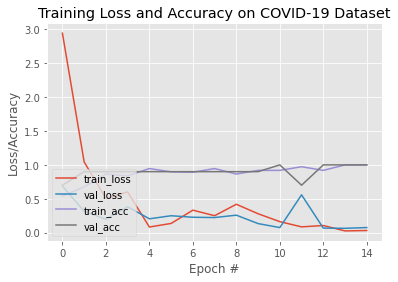

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


## Save the model

In [8]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("model_new.h5")

[INFO] saving COVID-19 detector model...


In [410]:
#to do: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia   we dont have two classes
#problems with dataset:
#pretty significant brightness/contrast changes between the images. The network could very well be just learning those differences.
#our model is learning patterns that are not relevant to COVID-19’ I was wondering if the images could be either made more uniform between sets, or going the other way processed so that variations are introduced in each sets.
#the Kaggle Pneumonia dataset consists of only pediatric patients (children), so there might be some bias!

#One should consider using Stanford’s CheXpert dataset or the NIH Chest X-ray dataset for negative cases instead.
#its bad also that pos and neg cases are from different sources
#https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/?unapproved=767412&moderation-hash=cddfb9ce59d1a275bab315816ef3f5e6&submitted_comment=1#comment-767412



In [411]:
#how can you trust the decisions of a model if you cannot properly validate how it arrived there?
#Using Grad-CAM, we can visually validate where our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns.

In [412]:
#If the network is not activating around the proper patterns/objects in the image, then we know:

#Our network hasn’t properly learned the underlying patterns in our dataset
#Our training procedure needs to be revisited
#We may need to collect additional data
#And most importantly, our model is not ready for deployment.

#good example here: https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
#tanks

# Grad-CAM  works only for cnn


## Detect image regions used by the CNN to identify that category.
## Gradient Class Activation Map (Grad-CAM) is used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


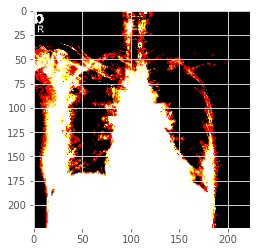

In [68]:
print(testY[-3])
img = testX[-3]
plt.imshow(img)
plt.show()

In [74]:
model.predict(img[np.newaxis,...])

array([[ 7.69103  , -5.2739778]], dtype=float32)

In [75]:
from vis.utils import utils
import tensorflow
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_12')
# Swap softmax with linear
model.layers[layer_idx].activation = tensorflow.keras.activations.linear
model = utils.apply_modifications(model)

In [79]:
import scipy
from vis.utils import utils
from vis.visualization import visualize_cam
penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
class_idx  = 0
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

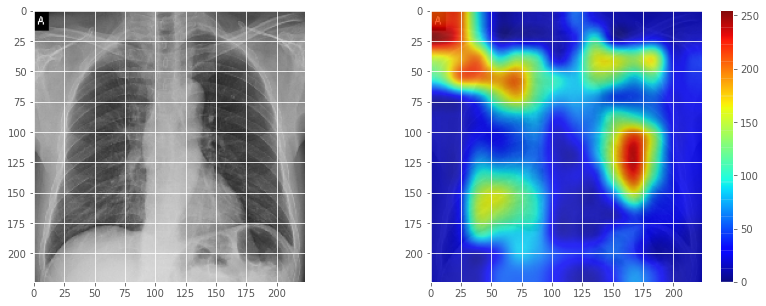

In [80]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)

plot_map(grad_top1)

In [409]:
#to do: tuning, dataset